In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')


In [67]:
def clean_trend_data(trend_df):

    
    trend_df['Week'] = pd.to_datetime(trend_df['Week'])
    trend_df['Year'] = pd.to_datetime(trend_df['Week']).dt.year
    trend_df['Month'] = pd.to_datetime(trend_df['Week']).dt.month

    # Convert count to numeric to avoid non-correlation
    trend_df['count'] = pd.to_numeric(trend_df['count'], errors='coerce')
    trend_df['count'] = trend_df['count'].fillna(1)


    return trend_df

In [144]:
ethereum_trends = pd.read_csv('trends/ethereum.csv')
ethereum_trends.head()

,Week,count
0,2019-04-07,3
1,2019-04-14,3
2,2019-04-21,3
3,2019-04-28,3
4,2019-05-05,3


In [145]:
eth_clean = clean_trend_data(ethereum_trends)
eth_clean.head()

,Week,count,Year,Month
0,2019-04-07,3,2019,4
1,2019-04-14,3,2019,4
2,2019-04-21,3,2019,4
3,2019-04-28,3,2019,4
4,2019-05-05,3,2019,5


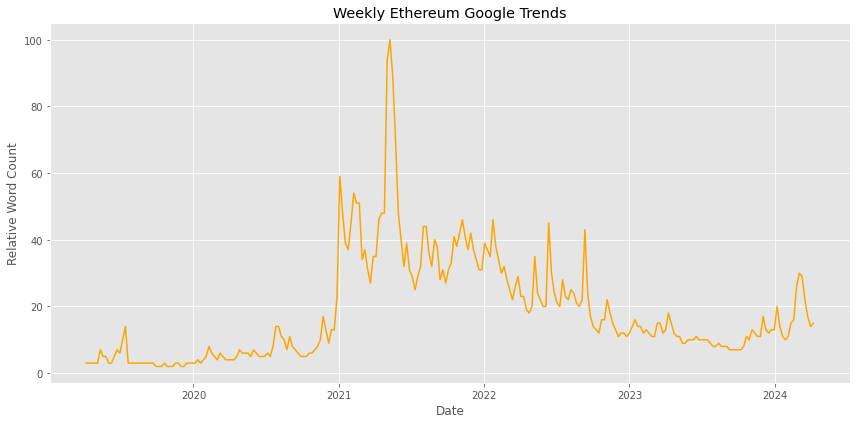

In [146]:
df1 = eth_clean.set_index('Week')['count']

plt.figure(figsize=(12,6))
plt.plot(df1, linewidth=1.5, color='orange')
plt.title("Weekly Ethereum Google Trends")
plt.xlabel('Date')
plt.ylabel('Relative Word Count')
plt.tight_layout()
plt.show()

In [147]:
def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('The timeseries is Stationary' if p_value < 0.05 else 'The timeseries is Non-Stationary\n')

print(f'The original time series')
check_stationarity(df1)

print(f'The first differences time series')
check_stationarity(df1.diff(1)[1:])

The original time series
ADF Statistic: -1.690832664611946
p-value: 0.43584184584256497
The timeseries is Non-Stationary

The first differences time series
ADF Statistic: -4.0723050128228735
p-value: 0.001075805532055656
The timeseries is Stationary


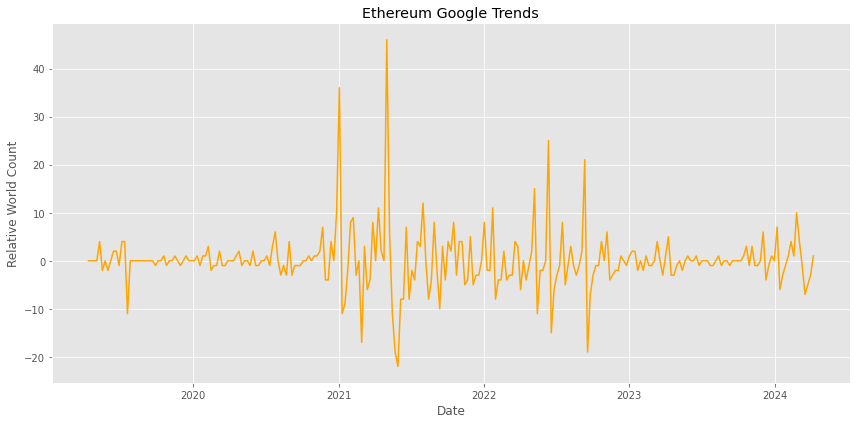

In [148]:
x = df1.diff(1)[1:]

plt.figure(figsize=(12,6))
plt.plot(x, linewidth=1.5, color='orange')
plt.title("Ethereum Google Trends")
plt.xlabel('Date')
plt.ylabel('Relative World Count')
plt.tight_layout()
plt.show()

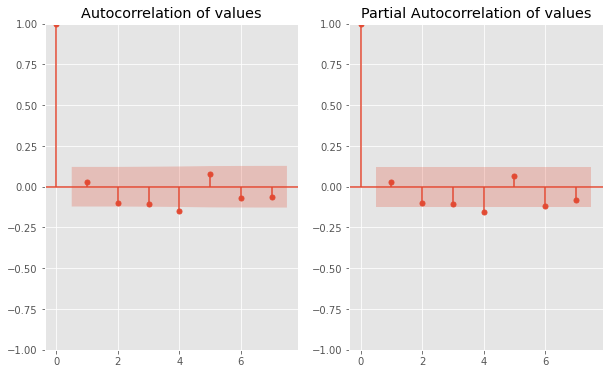

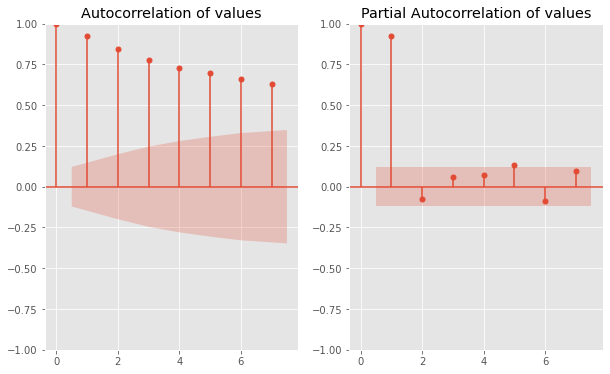

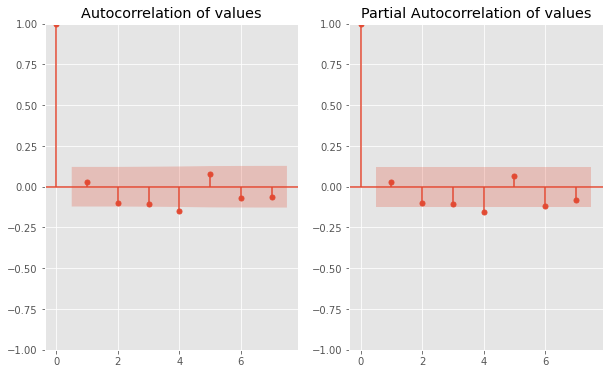

In [149]:
l = 7
_, ax = plt.subplots(1,2, figsize = (10,6))
plot_acf( df1, lags=l, ax = ax[0], title = 'Autocorrelation of values')
plot_pacf(df1, lags=l, ax = ax[1], title = 'Partial Autocorrelation of values')

_, ax = plt.subplots(1,2, figsize = (10,6))
plot_acf( x, lags=l, ax = ax[0], title = 'Autocorrelation of values')
plot_pacf(x, lags=l, ax = ax[1], title = 'Partial Autocorrelation of values')

In [150]:
import itertools
ps = range(0, 4) # by partial autocorr
ds = 1
qs = range(0, 4) # by autocorr



s = 52 # Assuming we have daily seasonality 
parameters = itertools.product(ps, [ds], qs, [0], [0], [0], [0])
parameters_list = list(parameters)
print(len(parameters_list))

16


In [151]:
def ts_metrics(y_true, y_pred):
    return {
        'mae': mean_absolute_error(y_true, y_pred),
        'mse': mean_squared_error(y_true, y_pred),
        #'mape': np.mean(np.abs((y_true - y_pred) / y_true)),
        # 'smape': np.mean(np.abs( 2*(y_true - y_pred) / (y_true+np.abs(y_pred)))),
        # 'nmse':  np.sum((y_true - y_pred)**2) / np.sum((y_true)**2),
    }

In [152]:
%%time
x = df1
list_param = []
list_res   = []
list_time  = []
list_pred  = []
import gc
import time
n = len(x)
n1 = 12

for p in parameters_list:
    t1 = time.time()
    list_res1 = list()
    list_pred1 = list()
    # train-valid split
    for k in range(1):
        train, valid = x[:-n1], x[-n1:]
        
        # train
        try:
            model_arima = SARIMAX(train, order=(p[0],p[1],p[2]), seasonal_order=(p[3],p[4],p[5],p[6]))
            model_arima = model_arima.fit(disp=-1)
        except Exception as e:
            print(p, e)
            break
            
        # predict
        pred = model_arima.predict(start = 0, end = n - 1)
        pred = pred[-n1:]
        list_pred1 += list(pred)
        
        # evaluate
        res = ts_metrics(valid, pred)
        list_res1.append(res)
        
        del model_arima
        gc.collect()
        
        # break
        
    # collect
    if len(list_pred1) > 0:
        list_pred.append(list_pred1)
        list_res.append(pd.DataFrame(list_res1).mean())
        list_time.append({'time':time.time() - t1})
        list_param.append(p)

CPU times: total: 3.2 s
Wall time: 5.2 s


In [153]:
# results
df_out = pd.concat([
    pd.DataFrame(list_param, columns = ['p','d','q','P','D','Q','S']),
    pd.DataFrame(list_res),
    pd.DataFrame(list_time),
], axis = 1).sort_values('mae')

df_out.drop(['P', 'D', 'Q', 'S', 'time'], axis=1,inplace=True)
df_out.reset_index(inplace = True)
del df_out['index']
df_out[:10]

,p,d,q,mae,mse
0,3,1,3,5.213427,49.901698
1,0,1,3,5.607330,61.684275
2,0,1,2,5.651759,62.134600
3,3,1,0,5.665398,62.708442
4,0,1,0,5.666667,61.500000
5,2,1,0,5.717891,62.906231
6,1,1,0,5.719345,62.352322
7,0,1,1,5.732587,62.572104
8,3,1,1,6.290785,73.160649
9,1,1,1,6.320056,71.489326


In [154]:
model = SARIMAX(x, order=(3, 1, 3), seasonal_order=(0, 0, 0, 0))
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  count   No. Observations:                  262
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -833.412
Date:                Sat, 27 Apr 2024   AIC                           1680.824
Time:                        20:29:21   BIC                           1705.775
Sample:                    04-07-2019   HQIC                          1690.853
                         - 04-07-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9159      0.132      6.955      0.000       0.658       1.174
ar.L2          0.5994      0.227      2.644      0.008       0.155       1.044
ar.L3         -0.7061      0.130     -5.452      0.000      -0.960      -0.452
ma.L1         -0.9483      0.126     -7.556      0.000      -1.194      -0.702
ma.L2         -0.7606      0.205     -3.705      0.000      -1.163      -0.358
ma.L3          0.8277      0.107      7.743      0.000       0.618       1.037
sigma2        34.6345      1.177     29.429      0.000      32.328      36.941
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3906.12
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               3.70   Skew:                             2.74
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

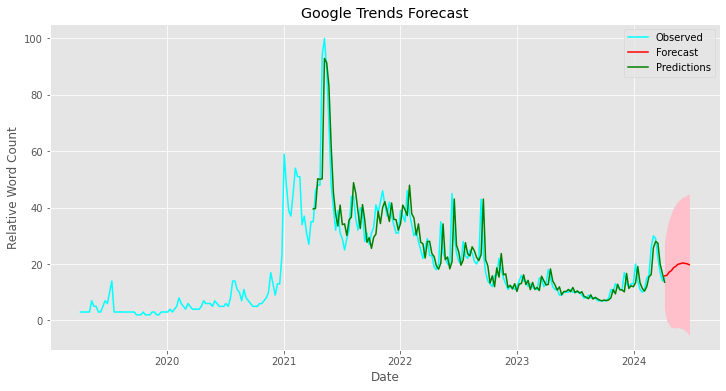

In [155]:
forecast_periods = 12 # Forecast the next 26 WEEKS
forecast = fitted_model.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
predictions = fitted_model.predict(start=104, steps=12)
 
start_date = eth_clean['Week'].max()

forecast_mean.index =  pd.date_range(start=start_date, periods=forecast_periods, freq='W')
forecast_ci.index =  pd.date_range(start=start_date, periods=forecast_periods, freq='W')
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(df1, label='Observed', color='cyan')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.plot(predictions, label='Predictions', color='green')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Google Trends Forecast")
plt.xlabel("Date")
plt.ylabel("Relative Word Count")
plt.legend()
plt.show()

Text(0, 0.5, 'Relative Word Count')

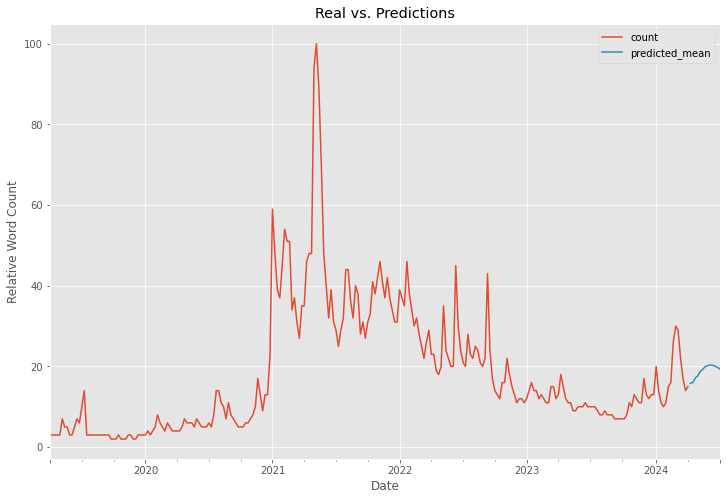

In [156]:
# make predictions

pred = fitted_model.predict(start = 1, end = n + n1)
# pred.index = pred.index + 2010
x.plot(figsize = (12,8), legend = 'real', title = 'Real vs. Predictions')
pred[-n1-1:].plot(figsize = (12,8), legend = 'prediction')
plt.xlabel('Date')
plt.ylabel('Relative Word Count')